In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
from scipy.optimize import curve_fit as cf

In [2]:
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.markersize'] = 4
mpl.rcParams['figure.autolayout'] = True
mpl.rcParams['font.size'] = 15
mpl.rcParams['errorbar.capsize'] = 3
mpl.rcParams['lines.markeredgewidth'] = 1
mpl.rcParams['axes.axisbelow'] = True

In [3]:
from math import floor
import scipy.stats as stats

dcmls = lambda x : -int(floor(np.log10(abs(x))))

round_error = lambda value,rounder : np.round(value,dcmls(rounder))

def chi2(y,y_err,x,func,popt):
    y_ajuste = func(x,*popt)
    chi_cuadrado = np.sum(((y-y_ajuste)/y_err)**2)
    return chi_cuadrado

def pvalue(y,y_err,x,func,popt):
    chi_cuadrado = chi2(y,y_err,x,func,popt)
    puntos = len(y)
    params = len(popt)
    grados_lib = puntos - params - 1
    pvalor = stats.chi2.sf(chi_cuadrado,grados_lib)
    return pvalor

## Calibración

In [4]:
converter = 10.6
err_converter = 0.5
px_to_mum = lambda px : px/converter
err_px_to_mum = lambda px,err_px : np.sqrt((err_px/converter)**2 + (px*err_converter/converter**2)**2)

In [5]:
def MSD_n(data,n):
    data[0] = np.array(data[0]) - data[0][0]
    data[1] = np.array(data[1]) - data[1][0]

    data = px_to_mum(data)
    err_0 = err_px_to_mum(data[0],np.ones_like(data[0])*0.5)
    err_1 = err_px_to_mum(data[1],np.ones_like(data[1])*0.5)

    if len(data[0]) != len(data[1]):
        print('Wrong size of data')
        return
    
    N = len(data[0])
    msd_n = 0
    err_n2 = 0
    for i in range(1,N-n):
        msd_n += 1/(N-(n+1)) * ((data[0][i+n] - data[0][i])**2 + (data[1][i+n] - data[1][i])**2)
        err_n2 += 1/(N-(n+1))**2 * (2*(data[0][i+n] - data[0][i])*err_0[i+n])**2 + (2*(data[0][i+n] - data[0][i])*err_0[i])**2 + (2*(data[1][i+n] - data[1][i])*err_1[i+n])**2 + (2*(data[1][i+n] - data[1][i])*err_1[i])**2
    err_n = np.sqrt(err_n2)
    return msd_n,err_n

def MSD(data):
    msds = []
    err_msds = []
    for n in range(len(data[0])-1):
        tup = MSD_n(data,n)
        msds.append(tup[0])
        err_msds.append(tup[1])
    return np.array(msds),np.array(err_msds)

In [6]:
from scipy.constants import k as k_B # J/K = kg*m**2/(s**2*K)
T = 20.3 + 273.15 # K
err_T = 0.1 # K
Rs = np.array([2.407,1.981,2.264,2.048,1.986,2.032,2.169,1.886,2.101]) # mum
err_inst_Rs = err_px_to_mum(Rs*10.6,np.ones_like(Rs)*0.5)
R = np.mean(Rs) # mum
err_R = np.sqrt(np.std(Rs)**2/Rs.shape[0] + 1/Rs.shape[0] * np.mean(err_inst_Rs**2)) # mum
print(round_error(R,err_R),round_error(err_R,err_R))

2.1 0.06


## Movimiento Browniano (solución 2)

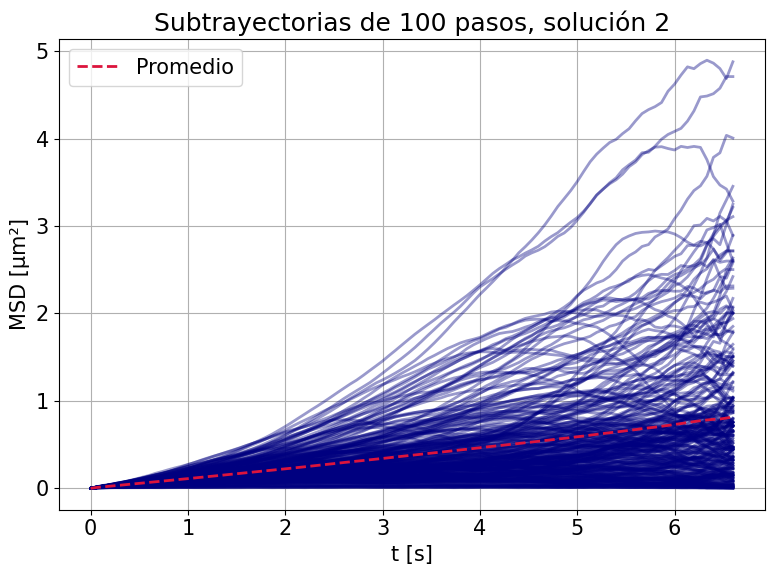

In [17]:
plt.figure(figsize=(8,6))
msds = []
err_msds = []
ts = np.arange(0,100)/15
for j in range(1,23):
    if j == 16:
        continue
    for i in range(12):
        data = np.loadtxt(f'trayectorias/browniano sol 2_0/{j}_tray_{i}.txt',skiprows=0,unpack=True)
        msd,err_msd = MSD(data)
        plt.plot(ts,msd,c='navy',alpha=0.4)
        msds.append(msd)
        err_msds.append(err_msd)
msds_array = np.stack(msds)
err_msds_array = np.stack(err_msds)
mean_msds = np.mean(msds_array,axis=0)
sigma_std = np.std(msds_array,axis=0)
N = msds_array.shape[0]
err_mean_msds = np.sqrt(sigma_std**2/N + 1/N * np.mean(err_msds_array**2,axis=0))

plt.plot(ts,np.mean(msds_array,axis=0),c='crimson',ls='--',label='Promedio')
plt.grid()
plt.xlabel('t [s]')
plt.ylabel('MSD [\u03BCm\u00b2]')
plt.legend()
plt.title('Subtrayectorias de 100 pasos, solución 2')
plt.tight_layout()
plt.savefig('plots/brownianos_2.png')

1.0


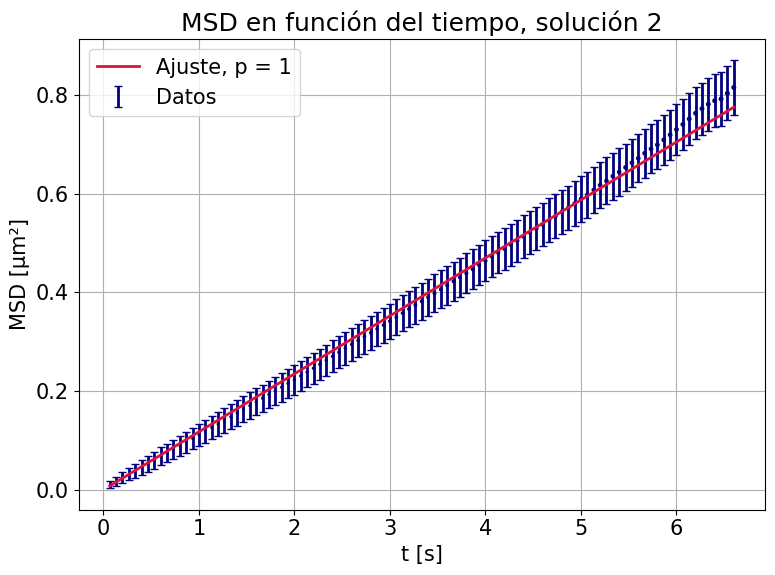

In [19]:
lineal0 = lambda x,a : a*x
pars,cov = cf(lineal0,ts[1:],mean_msds[1:],sigma=err_mean_msds[1:],absolute_sigma=True)

plt.figure(figsize=(8,6))
plt.scatter(ts[1:],mean_msds[1:],ts[1:],c='navy',zorder=2)
plt.errorbar(ts[1:],mean_msds[1:],yerr=err_mean_msds[1:],fmt='None',ecolor='navy',zorder=1,label='Datos')
plt.plot(ts[1:],lineal0(ts[1:],pars[0]),'crimson',zorder=3,label='Ajuste, p = 1')
plt.grid()
plt.xlabel('t [s]')
plt.ylabel('MSD [\u03BCm\u00b2]')
plt.legend()
plt.title('MSD en función del tiempo, solución 2')
plt.tight_layout()

D2 = pars[0]/4
err_D2 = np.sqrt(cov[0,0])/4
print(pvalue(mean_msds[1:],err_mean_msds[1:],ts[1:],lineal0,pars))
plt.savefig('plots/msd_2.png')

In [9]:
eta2 = k_B*T/(6*np.pi*D2*R*1e-18)*1000
err_eta2 = 1000*1e18*k_B/(6*np.pi) * np.sqrt((err_T/(D2*R))**2 + (T*err_D2/(D2**2*R))**2 + (T*err_R/(D2*R**2))**2)
print(f'\u03B7\u2082 = ({round_error(eta2,err_eta2)} \u00b1 {round_error(err_eta2,err_eta2)}) mPa s')
print(f'D\u2082 = ({round_error(D2,err_D2)} \u00b1 {round_error(err_D2,err_D2)}) \u03BCm\u00b2/s')

η₂ = (3.5 ± 0.1) mPa s
D₂ = (0.0294 ± 0.0003) μm²/s


## Movimiento Browniano (solución 1)

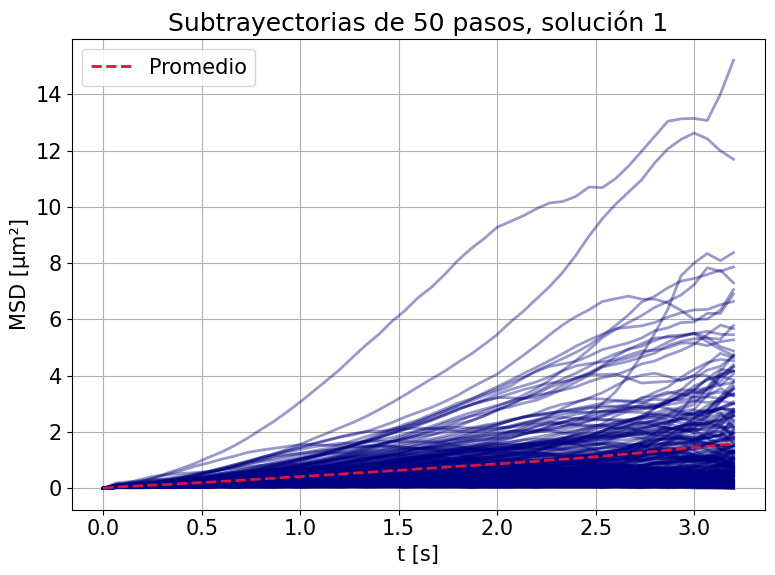

In [7]:
plt.figure(figsize=(8,6))
msds = []
err_msds = []
ts = np.arange(0,49)/15
for j in range(1,11):
    for i in range(6):
        data = np.loadtxt(f'trayectorias/browniano 1/video browniano 1_0/{j}_tray_{i}.txt',skiprows=0,unpack=True)
        if data.shape[1] == 101:
            msd1,err_msd1 = MSD(data[:,:50])
            msd2,err_msd2 = MSD(data[:,50:100])
            plt.plot(ts,msd1,c='navy',alpha=0.4)
            plt.plot(ts,msd2,c='navy',alpha=0.4)
            msds.append(msd1)
            msds.append(msd2)
            err_msds.append(err_msd1)
            err_msds.append(err_msd2)
for j in range(11,13):
    for i in range(5):
        data = np.loadtxt(f'trayectorias/browniano 1/Browniano/{j}_tray_{i}.txt',skiprows=0,unpack=True)
        if data.shape[1] == 101:
            msd1,err_msd1 = MSD(data[:,:50])
            msd2,err_msd2 = MSD(data[:,50:100])
            plt.plot(ts,msd1,c='navy',alpha=0.4)
            plt.plot(ts,msd2,c='navy',alpha=0.4)
            msds.append(msd1)
            msds.append(msd2)
            err_msds.append(err_msd1)
            err_msds.append(err_msd2)
for j in range(13,23):
    for i in range(5):
        data = np.loadtxt(f'trayectorias/browniano 1/Browniano_0/{j}_tray_{i}.txt',skiprows=0,unpack=True)
        if data.shape[1] == 101:
            msd1,err_msd1 = MSD(data[:,:50])
            msd2,err_msd2 = MSD(data[:,50:100])
            plt.plot(ts,msd1,c='navy',alpha=0.4)
            plt.plot(ts,msd2,c='navy',alpha=0.4)
            msds.append(msd1)
            msds.append(msd2)
            err_msds.append(err_msd1)
            err_msds.append(err_msd2)
msds_array = np.stack(msds)
err_msds_array = np.stack(err_msds)
mean_msds = np.mean(msds_array,axis=0)
sigma_std = np.std(msds_array,axis=0)
N = msds_array.shape[0]
err_mean_msds = np.sqrt(sigma_std**2/N + 1/N * np.mean(err_msds_array**2,axis=0))

plt.plot(ts,np.mean(msds_array,axis=0),c='crimson',ls='--',label='Promedio')
plt.grid()
plt.xlabel('t [s]')
plt.ylabel('MSD [\u03BCm\u00b2]')
plt.title('Subtrayectorias de 50 pasos, solución 1')
plt.legend()
plt.tight_layout()
plt.savefig('plots/brownianos_1.png')

0.9997960115801398


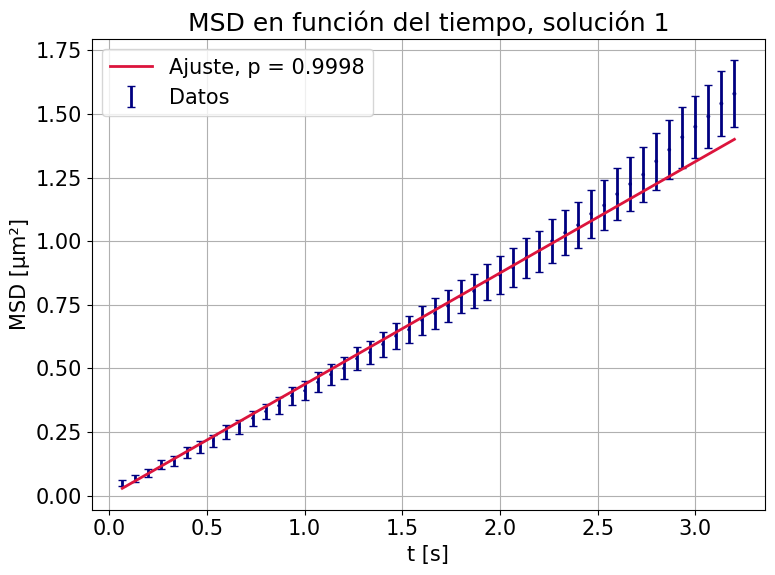

In [8]:
lineal0 = lambda x,a : a*x
pars,cov = cf(lineal0,ts[1:],mean_msds[1:],sigma=err_mean_msds[1:],absolute_sigma=True)

plt.figure(figsize=(8,6))
plt.scatter(ts[1:],mean_msds[1:],ts[1:],c='navy',zorder=2)
plt.errorbar(ts[1:],mean_msds[1:],yerr=err_mean_msds[1:],fmt='None',ecolor='navy',zorder=1,label='Datos')
plt.plot(ts[1:],lineal0(ts[1:],pars[0]),'crimson',zorder=3,label='Ajuste, p = 0.9998')
plt.grid()
plt.xlabel('t [s]')
plt.ylabel('MSD [\u03BCm\u00b2]')
plt.legend()
plt.title('MSD en función del tiempo, solución 1')
plt.tight_layout()
plt.savefig('plots/msd_1.png')

D1 = pars[0]/4
err_D1 = np.sqrt(cov[0,0])/4
print(pvalue(mean_msds[1:],err_mean_msds[1:],ts[1:],lineal0,pars))

In [9]:
eta1 = k_B*T/(6*np.pi*D1*R*1e-18)*1000
err_eta1 = 1000*1e18*k_B/(6*np.pi) * np.sqrt((err_T/(D1*R))**2 + (T*err_D1/(D1**2*R))**2 + (T*err_R/(D1*R**2))**2)
print(f'\u03B7\u2081 = ({round_error(eta1,err_eta1)} \u00b1 {round_error(err_eta1,err_eta1)}) mPa s')
print(f'D\u2081 = ({round_error(D1,err_D1)} \u00b1 {round_error(err_D1,err_D1)}) \u03BCm\u00b2/s')

η₁ = (0.94 ± 0.03) mPa s
D₁ = (0.109 ± 0.001) μm²/s


## Fuerza máxima (solución 1)

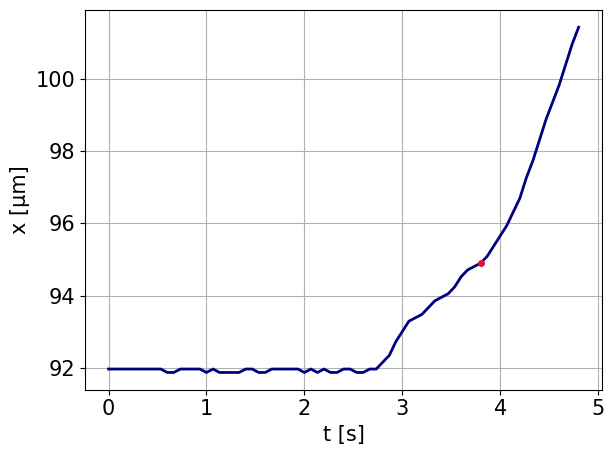

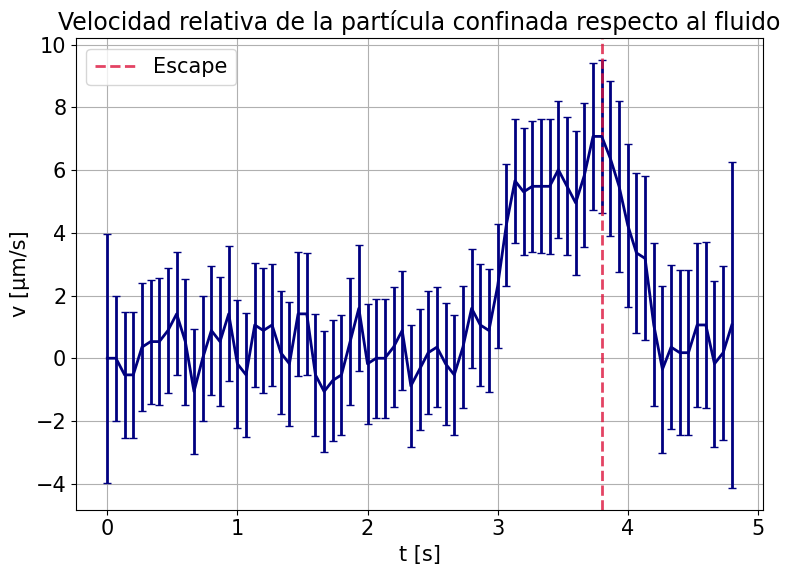

In [15]:
video = 'Pinza_2'
part_l = np.loadtxt(f'trayectorias/pinzas/{video}/0_tray.txt',skiprows=0,unpack=True)[0][:73]
parts_list = []
for i in range(1,6):
    parts_i = np.loadtxt(f'trayectorias/pinzas/{video}/{i}_tray.txt',skiprows=0,unpack=True)[0][:73]
    parts_list.append(parts_i)

h = 1/15

v_list = []
err_v_list = []
for i in range(4):
    v_list.append(np.gradient(px_to_mum(parts_list[i] - part_l),1/15))
    errores = np.zeros_like(part_l)
    error_i = err_px_to_mum(parts_list[i]-part_l,np.ones_like(parts_list[i])/4)
    errores[0] = 1/h*np.sqrt(error_i[1]**2+error_i[0]**2)
    for j in range(1,len(errores)-1):
        errores[j] = 1/(2*h)*np.sqrt(error_i[j+1]**2+error_i[j-1]**2)
    errores[-1] = 1/h*np.sqrt(error_i[-1]**2+error_i[-2]**2)
    err_v_list.append(errores)
v_array = np.stack(v_list)
err_v_array = np.stack(err_v_list)
v_mean = np.mean(v_array,axis=0)
v_std = np.std(v_array,axis=0)
N = v_array.shape[0]
err_v_mean = np.sqrt(v_std**2/N + 1/N * np.mean(err_v_array**2,axis=0))

plt.plot(np.arange(0,73)/15,px_to_mum(part_l),c='navy',zorder=1)
plt.scatter(57/15,px_to_mum(part_l[57]),c='crimson',zorder=2)
plt.grid()
plt.xlabel('t [s]')
plt.ylabel('x [\u03BCm]')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
plt.plot(np.arange(0,73)/15,v_mean,c='navy',zorder=3)
plt.errorbar(np.arange(0,73)/15,v_mean,yerr=err_v_mean,fmt='None',ecolor='navy',zorder=1)
plt.axvline(57/15,c='crimson',ls='--',alpha=0.8,label='Escape',zorder=2)
plt.grid()
plt.xlabel('t [s]')
plt.ylabel('v [\u03BCm/s]')
plt.legend()
plt.title('Velocidad relativa de la partícula confinada respecto al fluido',fontsize=17)
plt.tight_layout()
plt.savefig('plots/velocidad_mean.png')
plt.show()

In [14]:
v_escape = v_mean[57]
err_v_escape = err_v_mean[57]
print(f'v_escape = ({round_error(v_escape,err_v_escape)} \u00b1 {round_error(err_v_escape,err_v_escape)}) \u03BCm/s')

F_max = 6*np.pi*eta1*R*v_escape/1000
err_F_max = 6*np.pi*np.sqrt((err_eta1*R*v_escape)**2 + (eta1*err_R*v_escape)**2 + (eta1*R*err_v_escape)**2)/1000

print(f'F_max = ({round_error(F_max,err_F_max)} \u00b1 {round_error(err_F_max,err_F_max)}) pN')

v_escape = (7.0 ± 4.0) μm/s
F_max = (0.3 ± 0.1) pN
